---
# Apples to Apples
### John Thurman
---

## Table of Contents
* #### [Introduction](#Introduction)
    * [Define functions](#DefineFunctions)
    * [Loading Data](#LoadingData)
    * [Data exploration](#DataExploration)
* #### [Modelling fruit 360 data](#ModellingSection1)
    * [Random Forest Benchmark](#Benchmark)
    * [2 Convolution CNN](#Model1)
    * [4 Convolution CNN](#Model2)
    * [Transfer learning](#Model3)
    * [General Comments](#Comments1)
* #### [Modelling flickr data](#ModellingSection2)
    * [4 Convolution CNN](#Model4)
    * [Transfer learning](#Model5)
    * [General Comments](#Comments2)
* #### [Reduced fruit subset](#ModellingSection3)
    * [4 Convolutions CNN](#Model6)
    * [Transfer learning](#Model7)
    * [Hyper-parameter tuning](#Hyperparam)
    * [General Comments](#Comments3)
* #### [Other](#Other)
    * [Image Augmentation](#ImageAugmentation)





Load the appropriate libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
import os
import glob

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print('Tensorflow version \t:', tf.__version__)
print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name())

W0324 15:53:13.169288 16360 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Tensorflow version 	: 1.10.0
True True /device:GPU:0


<a id="Introduction"> </a>
# Introduction

The objective of this project is to determine whether image classification techniques can be used to distinguish between different types of fruit. The project looks at 4 general types of model:
* Random Forest Classifier (Used as a benchmark)
* A Convoltional Neural network (CNN) with 2 convolutional layers
* CNN with 4 convolutional layers
* CNN using transfer learning from a mobilenet (V2) model that has been trained on the Imagenet dataset.

The data used for this project has come from two sources:
* 'fruit-360' dataset produced by Horea Muresan, Mihai Oltean, and available at kaggle 
<a href='https://www.kaggle.com/moltean/fruits'> here </a> 
* A dataset that was compiled using the Flickr API with additional manual cleaning. A separate jupyter notebook has been included detailing the steps taken to collect this data

This project has been split into two sections, seperated by the two of data sources

<a id="DefineFunctions"></a>
# Defining useful functions 

These functions are used throughout the document in the analysis

In [2]:
#Metric for defining success. In addition to accr
def custom_accuracy(ytrue, ypred):
    '''
    An accuracy where we determine whether we manage to guess the product within the top 4 tries.
    '''
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning
def plt_history(history):
    '''
    For use with a keras based model.
    This model will plot the loss, accuracy and 'top4 accuracy' per epoch.
    '''
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   

def convert_to_supergroup(x):
    '''
    The fruit-360 data comes in 95 different varieties typically sub-species (e.g. Braeburn). The Flicker data comes
    just over 50 varieties typically super species (e.g. Apple). This converst sub-species to super specie.
    '''
    
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_x = pd.DataFrame(x, columns=['SubCategory'])
    return list((pd.merge(df_x, df_supergroup, on='SubCategory', how='left').loc[:,'Category']).values)

def plot_first_group(data, prediction_labels, truth_labels, number=15):
    '''
    This draws the first n
    '''
    plt.figure(figsize=(20,10))
    for count, photo in enumerate(prediction_labels[:number]):
        rows = (number-1)//5+1
        plt.subplot(rows,5, count+1)
        b,g,r = cv2.split(data[count,:,:,:])       
        rgb_img = cv2.merge([r,g,b]) 
        plt.imshow(rgb_img)
        plt.title(photo+'({}) ' .format(truth_labels[count]))
 
def load_data(directory, maxData=None, randomState=1):
    '''
    Loads the different data sets from file. Smaller (random) subsets can be taken for experimenting by using the MaxData and 
    random state parameters
    '''
    #Get list of all images in directory
    imagePaths = glob.glob(directory+'/*/*.jpg', recursive=True)
    
    if maxData is not None:
        np.random.set_state=randomState
        imagePaths = np.random.choice(imagePaths,size=maxData)
          
    X =[]
    y =[]
    for path in imagePaths:
        label = path.split("\\")[-2]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        X.append(image)
        y.append(label)
        
    return np.array(X), np.array(y)

<a id='LoadingData'></a>
# Load data

#### Fruit 360 data set

In [4]:
# Load training set
X,y = load_data('./data/fruits/fruits-360/Training',maxData=20000)

#Preprocess the data using a label encoder and diving by 255
label_encoder = LabelEncoder()
label_encoder.fit(y)
X = X/255
y = label_encoder.transform(y)

# Create train, validation split
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Save the label encoder to file
fileObject = open('labelEncoding.pkl','wb')
pickle.dump(label_encoder,fileObject)
fileObject.close()

In [5]:
# test data is a hold out set specificly identified in the data set. Load this data and preprocess
X_test,y_test = load_data('./data/fruits/fruits-360/Test', maxData=10000)
X_test = X_test/255
y_test = label_encoder.transform(y_test)

In [3]:
INPUTSHAPE = (100,100,3)
OUTPUTSHAPE = len(np.unique(y))
del X, y= #To free up space as otherwise there is a duplication of this data

#### Flickr data

In [4]:
# load data
X_flickr, y_flickr = load_data('./data/flickr')
X_flickr = X_flickr/255

#Create the reduced dataset:
fruitsubset = ['Strawberry', 'Apple', 'Lemon', 'Orange', 'Mango', 'Banana', 'Grape', 'Passion Fruit', 'Peach']
infruitsubset = np.in1d(y_flickr, fruitsubset)
X_flickr_subset = X_flickr[infruitsubset]
y_flickr_subset = y_flickr[infruitsubset]

#need a new encoder as the data has different labels than the fruit 360 dataset
label_encoder_flickr = LabelEncoder()

#transformation on data
y_flickr = label_encoder_flickr.fit_transform(y_flickr)
X_flickr_train, X_flickr_test, y_flickr_train, y_flickr_test = train_test_split(X_flickr, y_flickr,  test_size=300)
X_flickr_train, X_flickr_val, y_flickr_train, y_flickr_val = train_test_split(X_flickr_train, y_flickr_train,  test_size=0.2, train_size=0.8)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickr.pkl','wb')
pickle.dump(label_encoder_flickr,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKR = len(np.unique(y_flickr))

In [5]:
#need a new encoder as the data has different labels than the fruit 360 dataset (and smaller than the other flickr encoding)
label_encoder_flickr_subset = LabelEncoder()

#transformation on data
y_flickr_subset = label_encoder_flickr_subset.fit_transform(y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_test, y_flickr_subset_train, y_flickr_subset_test = train_test_split(X_flickr_subset, y_flickr_subset,  test_size=300)
X_flickr_subset_train, X_flickr_subset_val, y_flickr_subset_train, y_flickr_subset_val = train_test_split(X_flickr_subset_train, y_flickr_subset_train,  test_size=0.2, train_size=0.8)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickrSubset.pkl','wb')
pickle.dump(label_encoder_flickr_subset,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKRSUBSET = len(np.unique(y_flickr_subset))

#To free up space as otherwise there is a duplication of this data
del X_flickr, y_flickr

# Data Exploration <a id='DataExploration'></a>

In [ ]:
plt.figure(figsize=(30,12))
for i in range(120):
    plt.subplot(8,15,i+1)
    plt.imshow(X_train[i,:,:,:])
    #plt.title(y[i], size = 10)
    plt.axis('off')

In [ ]:
#Complete PCA - show results for some of the data:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

In [ ]:
# TSNE plot

tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

visualize_scatter(tsne_result_scaled, label_ids, id_to_label_dict, figsize=(25, 25))

<a id=ModellingSection1></a>
<a id=Benchmark></a>
# Modelling using fruit 360 training data
## Random Forest Benchmark

Completed for Flickr data and the fruit-360 dataset

In [ ]:
#Flatten the data
# Note that the data in the fruit 360 dataset is made up of 60000*30000*8(byte) floats -> This is 13GB of RAM needed to store. 
# Making a copy can be quite painful! The 
X_train_flat = X_train.reshape((len(X_train),30000))
X_test_flat = X_test.reshape((len(X_test), 30000))

X_flickr_train_flat = X_flickr_train.reshape((len(X_flickr_train),30000))
X_flickr_val_flat = X_flickr_val.reshape((len(X_flickr_val), 30000))

In [ ]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_train_flat, y_train)
print('Training accuracy \t: %.3f' % clf.score(X_train_flat, y_train))
print('Test accuracy \t\t: %.3f' % clf.score(X_test_flat, y_test))

In [ ]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_flickr_train_flat, y_flickr_train)
print('Training accuracy \t: %.3f' % clf.score(X_flickr_train_flat, y_flickr_train))
print('Test accuracy \t\t: %.3f'  % clf.score(X_flickr_val_flat, y_flickr_val))

<a id='Model1'> </a>
### Model 1 - Two layer convolutional neural network

In [7]:
#Define a model:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUTSHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(OUTPUTSHAPE, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 264)               8651016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
__________

In [8]:
# training model with early stopping
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
         
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=0)

Train on 15000 samples, validate on 5000 samples
Epoch 1/100
15000/15000 [==============================] - 33s 2ms/step - loss: 1.6393 - acc: 0.5781 - custom_accuracy: 0.7663 - val_loss: 0.1301 - val_acc: 0.9710 - val_custom_accuracy: 0.9998
Epoch 2/100
15000/15000 [==============================] - 29s 2ms/step - loss: 0.2764 - acc: 0.9112 - custom_accuracy: 0.9929 - val_loss: 0.0481 - val_acc: 0.9870 - val_custom_accuracy: 1.0000
Epoch 3/100
15000/15000 [==============================] - 28s 2ms/step - loss: 0.1619 - acc: 0.9470 - custom_accuracy: 0.9967 - val_loss: 0.0205 - val_acc: 0.9946 - val_custom_accuracy: 1.0000
Epoch 4/100
15000/15000 [==============================] - 29s 2ms/step - loss: 0.1277 - acc: 0.9558 - custom_accuracy: 0.9984 - val_loss: 0.0157 - val_acc: 0.9960 - val_custom_accuracy: 0.9998
Epoch 5/100
15000/15000 [==============================] - 29s 2ms/step - loss: 0.1034 - acc: 0.9666 - custom_accuracy: 0.9991 - val_loss: 0.0085 - val_acc: 0.9970 - val_custo

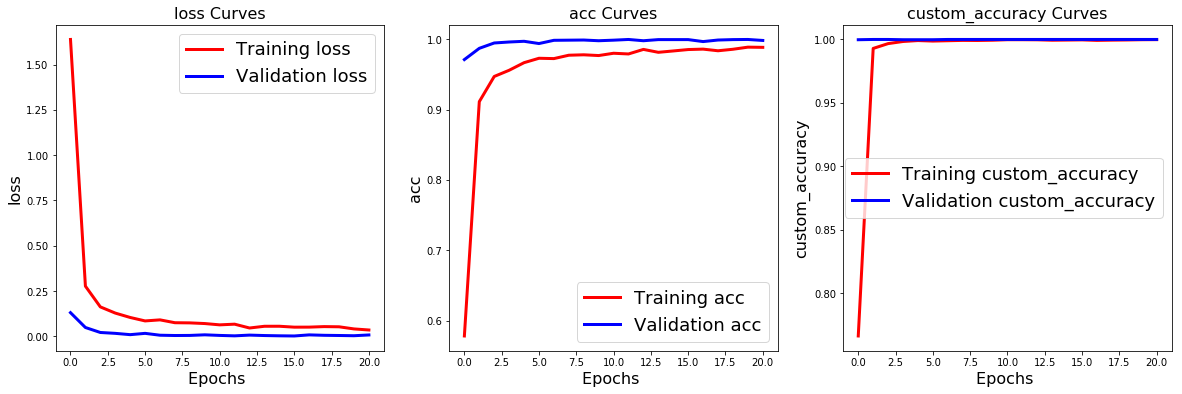

In [9]:
#plot the training history
plt_history(history)

In [21]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',model.evaluate(X_test, y_test, verbose=0)[1])

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple) and not 
# the subclass (e.g. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.9741
The accuracy of the model on a set of real life images:
Accuracy 	: 0.053


In [22]:
#save the model
path_weights = './saved_models/model1/weights.h5'
path_model = './saved_models/model1/model.json'

#Save Model
model_json = model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model.save_weights(path_weights)

This model made an improvement on the benchmark random forest classifier
<a id='Model2'></a>

## Model 2 - 4 layer convolutional neural network

In [23]:
class CNN4LayerModel():
    
    def __init__(self, outputshape, 
                 conv1filter = 32, conv1size=3, stride1=2,
                 conv2filter=32, conv2size=3,
                 conv3filter=64, conv3size=3,
                 conv4filter=64, conv4size=3, 
                 denseNodes1=128, dropout1=0.5):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Create Model
        self.model = Sequential()
        self.model.add(Conv2D(conv1filter,(conv1size,conv1size),padding='same',strides=(stride1,stride1),activation='relu'))
        self.model.add(Conv2D(conv2filter, (conv2size, conv2size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(conv3filter, (conv3size, conv3size),padding ='same',activation='relu'))
        self.model.add(Conv2D(conv4filter, (conv4size, conv4size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(denseNodes1, activation='relu'))
        self.model.add(Dropout(dropout1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy]) 
        
    def summarise(self):
        self.model.summary()

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)
                                    

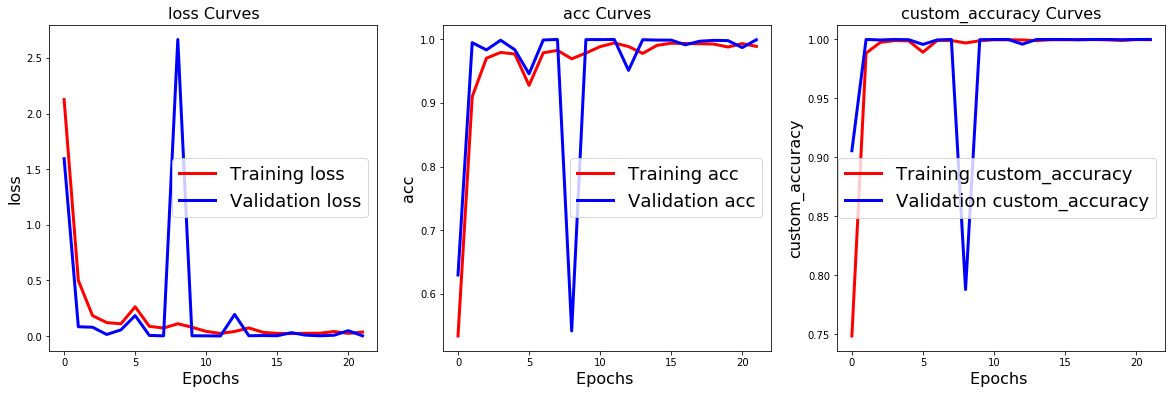

In [27]:
model2 = CNN4LayerModel(OUTPUTSHAPE)
model2.compile_model()
results = model2.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model2.plot_results()

In [28]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model2.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.982
The accuracy of the model on a set of real life images:
Accuracy 	: 0.047


In [29]:
path_weights = './saved_models/model2/weights.h5'
path_model = './saved_models/model2/model.json'

#Save Model
model_json = model2.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model2.model.save_weights(path_weights)

<a id='Model3'></a>
# Model 3 - Transfer learning model

In [6]:
class TransferLearningModel():
    
    def __init__(self, outputshape, dropout1=0.5, dropout2=0.5, denseNodes=264, \
                 featureVectorString='https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Get feature vector
        module = hub.Module(featureVectorString, trainable=False, name='featureVector')
        height, width = hub.get_expected_image_size(module)

        resize_layer = Lambda(lambda x: tf.image.resize_images(x, (height,width)), input_shape = INPUTSHAPE)
        FeatureVector128 = Lambda(module, input_shape = [height,width,3])
        
        #Create Model
        self.model = Sequential()
        self.model.add(resize_layer)
        self.model.add(FeatureVector128)
        self.model.add(Dropout(dropout1))
        self.model.add(Dense(denseNodes, activation='relu'))
        self.model.add(Dropout(dropout2))
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy])  

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0323 17:38:34.537710 17020 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


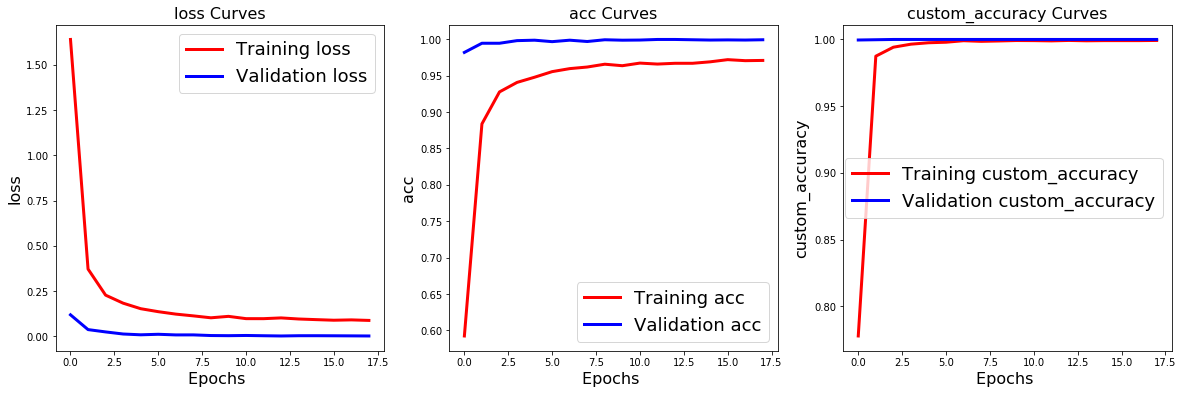

In [31]:
model3 = TransferLearningModel(OUTPUTSHAPE)
model3.compile_model()
#model3.summarise()
results = model3.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model3.plot_results()

In [32]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model3.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.977
The accuracy of the model on a set of real life images:
Accuracy 	: 0.217


In [33]:
path_weights = './saved_models/model3/weights.h5'
path_model = './saved_models/model3/model.json'

#Note that the model does not save using the path save_model method. 
model3.model.save_weights(path_weights)

<a id=Comments1></a>
## Commentary

To be completed


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = label_encoder.inverse_transform(y_test)
y_predict = label_encoder.inverse_transform(model3.predict_classes(X_flickr_))

plt.figure(figsize=(16,8))
sns.heatmap(-np.log(confusion_matrix(y_true, y_predict)));

<a id='ModellingSection2'></a> <a id="Model4"></a>
# Modelling using flickr training data
## Model 4 - 4 layer convolutional neural network


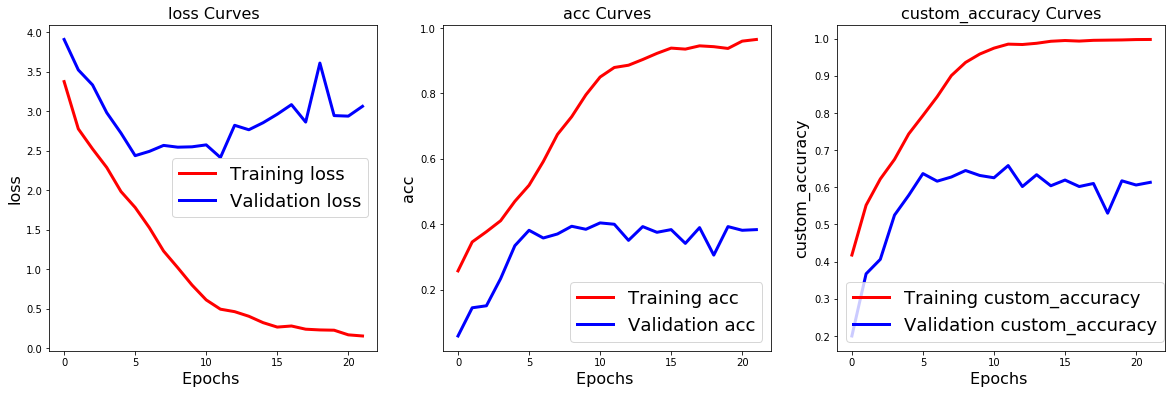

In [34]:
model4 = CNN4LayerModel(OUTPUTSHAPEFLICKR)
model4.compile_model()
#model4.summarise()
results = model4.get_results(X_flickr_train, y_flickr_train,X_flickr_val, y_flickr_val, X_flickr_test, y_flickr_test, verbose=0)
model4.plot_results()

In [35]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.34


In [37]:
path_weights = './saved_models/model4/weights.h5'
path_model = './saved_models/model4/model.json'

#Save Model
model_json = model4.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model4.model.save_weights(path_weights)

<a id="Model5"></a>
## Model 5 - Transfer learning using Mobilenet V2

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0323 17:53:15.744680 17020 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


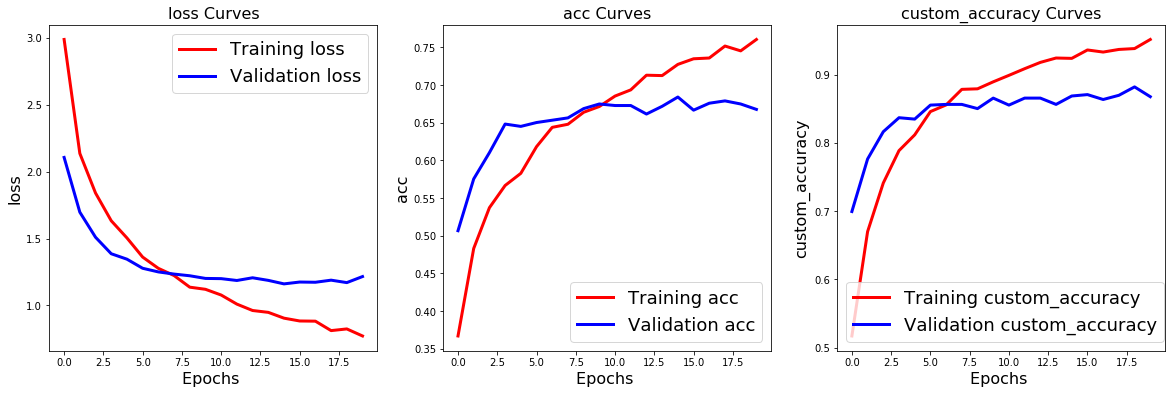

In [38]:
model5 = TransferLearningModel(OUTPUTSHAPEFLICKR)
model5.compile_model()
#model5.summarise()
results = model5.get_results(X_flickr_train, y_flickr_train,
                             X_flickr_val, y_flickr_val, 
                             X_flickr_test, y_flickr_test, verbose=0)
model5.plot_results()

In [39]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.63


In [40]:
path_weights = './saved_models/model5/weights.h5'
path_model = './saved_models/model5/model.json'

#Note that the model does not save using the path save_model method. 
model5.model.save_weights(path_weights)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score

y_true = y_flickr_val
y_predict = model5.model.predict_classes(X_flickr_val)

plt.figure(figsize=(16,8))
sns.heatmap(-np.log(confusion_matrix(y_true, y_predict)));

# Training a model on a reduced fruit subset <a id='ModellingSection3'></a>
## Model 6 - 4 Convolutional layers CNN <a id='Model6'></a>

Train on 2281 samples, validate on 571 samples
Epoch 1/100
2281/2281 [==============================] - 7s 3ms/step - loss: 1.7904 - acc: 0.4077 - custom_accuracy: 0.7904 - val_loss: 2.1206 - val_acc: 0.1856 - val_custom_accuracy: 0.6445
Epoch 2/100
2281/2281 [==============================] - 3s 1ms/step - loss: 1.3656 - acc: 0.5520 - custom_accuracy: 0.8851 - val_loss: 2.1798 - val_acc: 0.3100 - val_custom_accuracy: 0.6025
Epoch 3/100
2281/2281 [==============================] - 2s 1ms/step - loss: 1.1623 - acc: 0.5962 - custom_accuracy: 0.9215 - val_loss: 1.9692 - val_acc: 0.2539 - val_custom_accuracy: 0.7671
Epoch 4/100
2281/2281 [==============================] - 2s 1ms/step - loss: 1.0605 - acc: 0.6357 - custom_accuracy: 0.9395 - val_loss: 1.6160 - val_acc: 0.4011 - val_custom_accuracy: 0.8529
Epoch 5/100
2281/2281 [==============================] - 2s 1ms/step - loss: 0.8534 - acc: 0.7023 - custom_accuracy: 0.9575 - val_loss: 1.6102 - val_acc: 0.3905 - val_custom_accuracy: 0.868

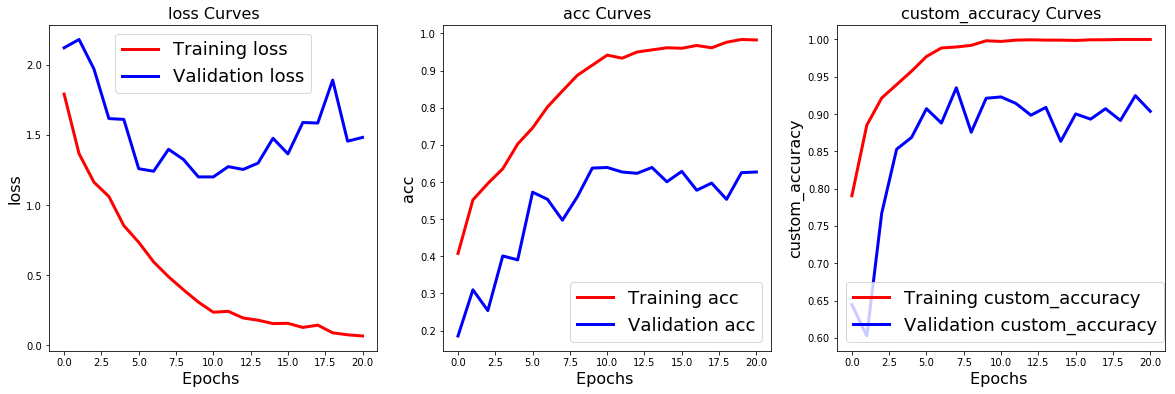

In [41]:
model6 = CNN4LayerModel(OUTPUTSHAPEFLICKRSUBSET)
model6.compile_model()
results = model6.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=1)
model6.plot_results()

In [42]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.61


In [43]:
path_weights = './saved_models/model6/weights.h5'
path_model = './saved_models/model6/model.json'

#Save Model
model_json = model6.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model6.model.save_weights(path_weights)

# Model 7 - Transfer learning using the Mobilenet V2 model <a id='Model7'></a>

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0323 18:10:54.839935 17020 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Train on 2281 samples, validate on 571 samples
Epoch 1/100
2281/2281 [==============================] - 10s 4ms/step - loss: 1.3663 - acc: 0.5954 - custom_accuracy: 0.8658 - val_loss: 0.6249 - val_acc: 0.7986 - val_custom_accuracy: 0.9685
Epoch 2/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.7115 - acc: 0.7716 - custom_accuracy: 0.9619 - val_loss: 0.5314 - val_acc: 0.8266 - val_custom_accuracy: 0.9772
Epoch 3/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.5876 - acc: 0.8067 - custom_accuracy: 0.9781 - val_loss: 0.4623 - val_acc: 0.8511 - val_custom_accuracy: 0.9860
Epoch 4/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.5286 - acc: 0.8299 - custom_accuracy: 0.9820 - val_loss: 0.4339 - val_acc: 0.8581 - val_custom_accuracy: 0.9877
Epoch 5/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.4768 - acc: 0.8369 - custom_accuracy: 0.9833 - val_loss: 0.4632 - val_acc: 0.8651 - val_custom_accuracy: 0.98

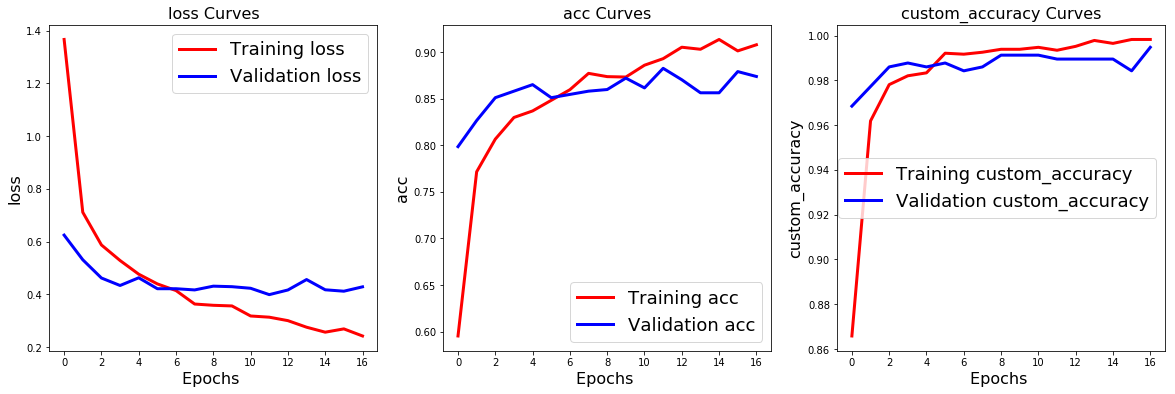

In [44]:
model7 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
model7.compile_model()
#model7.summarise()
results = model7.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=1)
model7.plot_results()

In [45]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.847


In [46]:
path_weights = './saved_models/model7/weights.h5'
model7.model.save_weights(path_weights)

# Hyper parameter tuning <a id='Hyperparam'></a>

### Grid search a number of alternative parameters for the model

In [10]:
#Number of repeats for averaging:
repeats=3 

featureModels = [#"https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2"]#,
                #"https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2"]

results = []
counter=0
for dropout1 in [0.1,0.2,0.3]:
    for dropout2 in [0.1, 0.2,0.3]:
        for denseNodes in [128,256,512]:
            for featureVectorString in featureModels:
                for repeat in range(repeats):
                    counter +=1
                    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, 
                                                  dropout1, dropout2, 
                                                  denseNodes, featureVectorString)
                    model.compile_model()
                    model_results = model.get_results(X_flickr_subset_train, y_flickr_subset_train,
                                                 X_flickr_subset_val, y_flickr_subset_val, 
                                                 X_flickr_subset_test, y_flickr_subset_test, verbose=0)
                    print('Model'+ counter, 'Test Accuracy: ' model_results['Test Accuracy'])
                    results.append(model_results)
                    K.clear_session() #reduces the memory footprint
                    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:29:16.912010 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.5, 'Test Accuracy': 0.836666665871938, 'dropout1': 0.25, 'Training Top-4 Accuracy': 0.9991231915826392, 'self': <__main__.TransferLearningModel object at 0x000001EAC82D3C18>, 'Training Accuracy': 0.9644892590968873, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8669001764883719, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:29:57.724323 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9894921201331812, 'dropout2': 0.5, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EAFEF265F8>, 'Training Accuracy': 0.9710653222270934, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8669001764883719, 'Test Top-4 Accuracy': 0.9833333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:31:11.554828 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947471034088, 'dropout2': 0.5, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EB03534278>, 'Training Accuracy': 0.977202981148619, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8756567428700769, 'Test Top-4 Accuracy': 0.9833333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:31:49.568120 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.991243433618295, 'dropout2': 0.5, 'Test Accuracy': 0.8533333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB08ABEEB8>, 'Training Accuracy': 0.9807102148180622, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8721541169437135, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:32:24.005955 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9894921183586121, 'dropout2': 0.5, 'Test Accuracy': 0.8666666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EAE7EC0588>, 'Training Accuracy': 0.9824638316527838, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8633975484742801, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:32:58.125670 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9824868661927258, 'dropout2': 0.5, 'Test Accuracy': 0.85, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB10EA4F98>, 'Training Accuracy': 0.9767645769660696, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:33:36.858071 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9859894931629535, 'dropout2': 0.5, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB14443C18>, 'Training Accuracy': 0.9846558526961858, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8616462360330305, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:34:10.351468 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8666666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB1AA05898>, 'Training Accuracy': 0.9785181938007912, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8616462349891663, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:34:59.512906 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8466666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB1A87BB00>, 'Training Accuracy': 0.9855326611135466, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8721541169437135, 'Test Top-4 Accuracy': 0.9866666674613953} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:35:32.224415 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8533333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB29561198>, 'Training Accuracy': 0.9833406400962756, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8756567428700769, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:36:16.796140 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8533333333333334, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB30AFDDD8>, 'Training Accuracy': 0.9824638316527838, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8651488619593939, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:36:55.601318 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947471034088, 'dropout2': 0.75, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB3809AA58>, 'Training Accuracy': 0.9833406400701447, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8651488630032581, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:37:51.638736 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.991243433618295, 'dropout2': 0.75, 'Test Accuracy': 0.8566666666666667, 'dropout1': 0.25, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EB3F6466D8>, 'Training Accuracy': 0.9881630863656291, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8598949225479166, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:38:43.410251 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.85, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB46BE7358>, 'Training Accuracy': 0.9868478737395879, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8791593698403046, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:39:27.948066 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8533333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB4E170F98>, 'Training Accuracy': 0.9846558526961858, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8598949225479166, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:40:09.477801 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB55720C18>, 'Training Accuracy': 0.9850942569048663, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8633975495181443, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:41:51.208626 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB59DC9B38>, 'Training Accuracy': 0.9877246821569488, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8826619978543965, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:42:29.362547 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.75, 'Test Accuracy': 0.8466666658719381, 'dropout1': 0.25, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB632497B8>, 'Training Accuracy': 0.9868478737657188, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8651488630032581, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:43:09.568977 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9964973730297724, 'dropout2': 0.5, 'Test Accuracy': 0.8533333325386048, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB6A815438>, 'Training Accuracy': 0.9881630863656291, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8721541169437135, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:43:47.850557 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8533333333333334, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB71D9FE80>, 'Training Accuracy': 0.9912319158263919, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8669001764883719, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:44:50.549809 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.5, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EB7934FCF8>, 'Training Accuracy': 0.9934239368697939, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8616462360330305, 'Test Top-4 Accuracy': 0.9900000007947286} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:45:33.283480 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9894921201331812, 'dropout2': 0.5, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB808FC978>, 'Training Accuracy': 0.9925471284524331, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:46:33.154304 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.5, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB87EB65F8>, 'Training Accuracy': 0.9890398947829899, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8791593698403046, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:47:15.699470 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.5, 'Test Accuracy': 0.8433333333333334, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB8F488278>, 'Training Accuracy': 0.9890398947829899, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:47:49.614732 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9964973730297724, 'dropout2': 0.5, 'Test Accuracy': 0.85, 'dropout1': 0.5, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EB96A53EB8>, 'Training Accuracy': 0.9859710653222271, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8704028024147354, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:48:44.410130 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.5, 'Test Accuracy': 0.8666666674613953, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EB9DFF2B38>, 'Training Accuracy': 0.9916703200350724, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:49:18.174257 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8533333333333334, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBA55AC7B8>, 'Training Accuracy': 0.9894782989916703, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8721541151691443, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:49:59.798893 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8600000007947286, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBACB4C438>, 'Training Accuracy': 0.9903551074090311, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8756567428700769, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:50:52.059074 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9877408066480673, 'dropout2': 0.75, 'Test Accuracy': 0.84, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBB2E4DA58>, 'Training Accuracy': 0.9934239368697939, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8704028024147354, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:51:56.582446 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9877408056042032, 'dropout2': 0.75, 'Test Accuracy': 0.8499999992052714, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBBA6BED30>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8774080563551908, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:52:32.834455 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.75, 'Test Accuracy': 0.8500000007947286, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBC1C419B0>, 'Training Accuracy': 0.9886014905743095, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8756567428700769, 'Test Top-4 Accuracy': 0.9900000007947286} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:53:17.518932 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8700000007947286, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBC91EB630>, 'Training Accuracy': 0.9916703200350724, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514899734857, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:53:51.425138 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8633333325386048, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBD07BE2B0>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8791593698403046, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:54:37.157783 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8466666658719381, 'dropout1': 0.5, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EBD7E57EF0>, 'Training Accuracy': 0.9890398947829899, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8704028034585997, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:55:23.929648 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBDF589B70>, 'Training Accuracy': 0.9934239368697939, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8616462342584613, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:56:04.274708 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.75, 'Test Accuracy': 0.85, 'dropout1': 0.5, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBE6C627F0>, 'Training Accuracy': 0.9947391494958352, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8704028034585997, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:56:52.407929 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.84, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBEE221470>, 'Training Accuracy': 0.9877246821830796, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8669001747138029, 'Test Top-4 Accuracy': 0.9933333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:57:26.484769 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8566666674613953, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBF57A8518>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8791593691095997, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:58:32.653728 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.5, 'Test Accuracy': 0.8466666658719381, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EBFCD6ED30>, 'Training Accuracy': 0.9916703200350724, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8721541151691443, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:59:28.554962 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.85, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC043189B0>, 'Training Accuracy': 0.9951775537045155, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8581436072882337, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:00:08.680608 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.991243433618295, 'dropout2': 0.5, 'Test Accuracy': 0.8633333341280619, 'dropout1': 0.75, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EC0B8D5630>, 'Training Accuracy': 0.9925471284524331, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8528896661021872, 'Test Top-4 Accuracy': 0.99} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:00:55.963106 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8566666666666667, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC12E962B0>, 'Training Accuracy': 0.9934239368697939, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514899734857, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:01:36.204443 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.5, 'Test Accuracy': 0.8500000007947286, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC1A42FEF0>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8633975477435751, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:02:14.757297 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.5, 'Test Accuracy': 0.8366666666666667, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC219E0B70>, 'Training Accuracy': 0.9907935116177116, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8686514899734857, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:03:09.181688 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.5, 'Test Accuracy': 0.8400000007947286, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC28FAC7F0>, 'Training Accuracy': 0.9916703200350724, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8704028024147354, 'Test Top-4 Accuracy': 0.98} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:03:57.584189 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.75, 'Test Accuracy': 0.8533333341280619, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC3056C470>, 'Training Accuracy': 0.9938623410784744, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8739054293849631, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:04:39.586676 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9947460595446584, 'dropout2': 0.75, 'Test Accuracy': 0.8533333333333334, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC37B01EB8>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8704028024147354, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:05:15.399860 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8566666666666667, 'dropout1': 0.75, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EC3C1E6160>, 'Training Accuracy': 0.9929855326611136, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 128, 'Validation Accuracy': 0.8826619978543965, 'Test Top-4 Accuracy': 0.9833333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:05:58.311054 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947471034088, 'dropout2': 0.75, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC46617DA0>, 'Training Accuracy': 0.9934239368697939, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8598949215040524, 'Test Top-4 Accuracy': 0.9833333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:06:55.380369 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9964973730297724, 'dropout2': 0.75, 'Test Accuracy': 0.8533333333333334, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC4DBC7A20>, 'Training Accuracy': 0.9925471284524331, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.9833333341280619} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:07:31.711167 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8533333325386048, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC551636A0>, 'Training Accuracy': 0.9921087242437527, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 256, 'Validation Accuracy': 0.8686514899734857, 'Test Top-4 Accuracy': 0.9866666666666667} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:08:21.266234 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.991243433618295, 'dropout2': 0.75, 'Test Accuracy': 0.8566666658719381, 'dropout1': 0.75, 'Training Top-4 Accuracy': 0.9995615957913196, 'self': <__main__.TransferLearningModel object at 0x000001EC5C710320>, 'Training Accuracy': 0.9929855326611136, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8721541169437135, 'Test Top-4 Accuracy': 0.9833333333333333} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:09:35.590383 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9929947460595446, 'dropout2': 0.75, 'Test Accuracy': 0.8333333325386048, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC63CADF60>, 'Training Accuracy': 0.9899167032003507, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8686514899734857, 'Test Top-4 Accuracy': 0.98} 

Starting model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:10:13.151941 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


{'Validation Top-4 Accuracy': 0.9912434325744308, 'dropout2': 0.75, 'Test Accuracy': 0.8566666674613953, 'dropout1': 0.75, 'Training Top-4 Accuracy': 1.0, 'self': <__main__.TransferLearningModel object at 0x000001EC6B280BE0>, 'Training Accuracy': 0.9925471284524331, 'featureVectorString': 'https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2', 'outputshape': 9, 'denseNodes': 512, 'Validation Accuracy': 0.8686514889296216, 'Test Top-4 Accuracy': 0.99} 



In [11]:
results = pd.DataFrame(results) #
results.to_csv('hyper-param.csv', sep='\t')

In [27]:
#del results['self']
metrics = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
           'Training Top-4 Accuracy', 'Validation Top-4 Accuracy', 'Test Top-4 Accuracy']

#group across all runs
non_metrics = [x for x in results.columns if x not in metrics]
grouped_results = results.groupby(by=non_metrics).mean()
grouped_results.sort_values('Test Accuracy', ascending=False).head()

Test Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                  
256        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                 0.872222   
128        0.25     0.50     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                 0.872222   
                    0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                 0.871111   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                 0.868889   
512        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                 0.867778   

                                                                                             Test Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                        
256        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.990000   
128        0.25     0.50     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.995556   
                    0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.996667   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.995556   
512        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.983333   

                                                                                             Training Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                      
256        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                     0.962005   
128        0.25     0.50     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                     0.933070   
                    0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                     0.954552   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                     0.951483   
512        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                     0.957183   

                                                                                             Training Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                            
256        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                           0.999415   
128        0.25     0.50     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                           0.999269   
                    0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                           0.999708   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                           0.999562   
512        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                           1.000000   

                                                                                             Validation Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                        
256        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.894337   
128        0.25     0.50     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.912434   
                    0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.899591   
                             https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.891419   
512        0.25     0.25     https://tfhub.dev/google/imagenet/mobilenet_v2_... 9                       0.890251   

                                                        

# Model 8 - retrain model based on best hyperparameters

In [ ]:
TBC

##  General Comments <a id='Comments3'></a>

In [ ]:
TBC

# Model 9 -  Image Augmentation

In [49]:
model9 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET,0.2, 0.2, 256, 
                               "https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2")
model9.compile_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 12:52:27.143348 16360 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [51]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    zoom_range=[0.1,0.0],
   # width_shift_range=None,
    #height_shift_range=None,
    horizontal_flip=True)

datagen.fit(X_flickr_subset_train)

In [52]:
cp_earlystop = EarlyStopping(monitor='val_acc', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model9.model.fit_generator(datagen.flow(X_flickr_subset_train, y_flickr_subset_train, batch_size=64),
                    steps_per_epoch=len(X_flickr_subset_train) / 64, epochs=100,
                    callbacks=[cp_earlystop],
                    validation_data = (X_flickr_subset_val, y_flickr_subset_val), verbose=1)

plt_history(history)

Epoch 1/1000
35/35 [============================>.] - ETA: 0s - loss: 1.9085 - acc: 0.3195 - custom_accuracy: 0.7270

InvalidArgumentError: You must feed a value for placeholder tensor 'lambda_4_input' with dtype float and shape [?,100,100,3]
	 [[Node: lambda_4_input = Placeholder[dtype=DT_FLOAT, shape=[?,100,100,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: lambda_5/featureVector_2_apply_default/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/ReadVariableOp_1/_87530 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_725_l...riableOp_1", _device="/job:localhost/replica:0/task:0/device:CPU:0"](lambda_5/featureVector_2_apply_default/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/ReadVariableOp_1)]]

In [47]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',model9.model.evaluate(X_flickr_subset_test, y_flickr_subset_test, verbose=0))

The accuracy of the model on a test set:
Accuracy 	: [0.6411756634712219, 0.8133333325386047, 0.9833333333333333]


In [ ]:
path_weights = './saved_models/model6/weights.h5'

#Note, cannot save model with this version of Tensorflow
model6.save_weights(path_weights)

## For the bin

# Experimental


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

#.vgg16 import VGG16, preprocess_input

base_pretrained_model = InceptionResNetV2(input_shape = (139,139,3), 
                              include_top = False, 
                                weights = 'imagenet', 
                                input_tensor=None)
base_pretrained_model.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(lr=1e-5)


resize_layer = Lambda(lambda x: tf.image.resize_images(x, (139,139)), input_shape = (100,100,3))

model7 = Sequential()
model7.add(resize_layer)
model7.add(base_pretrained_model)
model7.add(Flatten())
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.25))
model7.add(Dense(51, activation='softmax'))
model7.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model7.summary()


In [ ]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model7.fit(X_flickr_train, y_flickr_train,
                     batch_size=32,
                    validation_data = (X_flickr_val, y_flickr_val),
                    callbacks = [cp_earlystop],
                    epochs=100)